In [21]:
#load pip libraries
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import skmultiflow as sci_flow
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.evaluation import EvaluatePrequential
from datetime import datetime
import time
import os
import random

#load custom libraries
from funcs.IoTDevice import IoTDevice
import funcs.generate_state_data as generate_state_data

In [22]:
def inject_incident(df_dict, incident):
    if incident["type"] == "Overheating":
        candidate = [df for df in df_dict if "motor" in df.lower()]
        
        if len(candidate) > 0:
            target_df = random.choice(candidate)
            print(f"Injecting incident into {target_df}")

            anomaly = {
                "HappenTime": incident["startTime"],
                "length": incident["duration"],
                "Type": "Overheat",
                "Value": random.uniform(95, 105),
                "tag": "temperature",
            }
            
            other_tag = []

            for i, df in enumerate(df_dict[target_df]):
                
                if "sensor" in df.columns and df["sensor"].iloc[0] == "temperature":
                    df_dict[target_df][i] = generate_state_data.inject_anomaly_by_time(df, anomaly, "temperature")
                else:
                    other_tag.append(df["sensor"].iloc[0])
                
            selected_others = random.sample(other_tag, k=random.randint(0, min(2, len(other_tag))))

            for related_sensor in selected_others:
                anomaly = {
                    "HappenTime": incident["startTime"],
                    "length": incident["duration"],
                    "Type": "OverheatRelated",
                    "Value": random.uniform(1.2, 2.0),  # multiplier spike
                    "tag": "temperature"
                }
                for i, df in enumerate(df_dict[target_df]):
                    if "sensor" in df.columns and df["sensor"].iloc[0] == related_sensor:
                        df_dict[target_df][i] = generate_state_data.inject_anomaly_by_time(df, anomaly, "temperature")

            

    return df_dict

            



In [23]:
device_path = "../json_folder/device_config.json"
synth_path = "../json_folder/synthetic_config.json"
deivce_instance_path = "../json_folder/device_instance_map.json"

# load the amount of devices to be generated
with open(deivce_instance_path, 'r') as file:
    device_count = json.load(file)


dfs_dict = {}
combined_df_dict = {}

deivce_file = open(device_path, 'r')
device_json = json.load(deivce_file)
deivce_file.close()

synth_file = open(synth_path, 'r')
synth_json = json.load(synth_file)
synth_file.close()

for name, config in device_json["devices"].items():
    # print(name)

    device = IoTDevice()
    device.load_json(device_path, synth_path, name)

    gen_number = device_count.get(name, 1)
    # print(name, gen_number) #debug

    for i in range(gen_number):
        synth_id = f"{name}_{i}"
        dfs, combined_df = generate_state_data.device_data_generation(device, i) # passing i for inject at specific device

        dfs_dict[synth_id] = dfs
        combined_df_dict[synth_id] = combined_df
    

dfs_dict = inject_incident(dfs_dict,   {
    "type": "Overheating",
    "startTime": "2025-04-07T14:30:00Z",
    "duration": "10min"
  }) #debug




Skipping sensor yield — no 'states' defined.
Injecting incident into motor_monitor_0
⚠️ Injecting anomaly for temperature at 2025-04-07 14:30:00 with value 1.9848214861869946
⚠️ Injecting anomaly for temperature at 2025-04-07 14:30:00 with value 1.9872989514634174


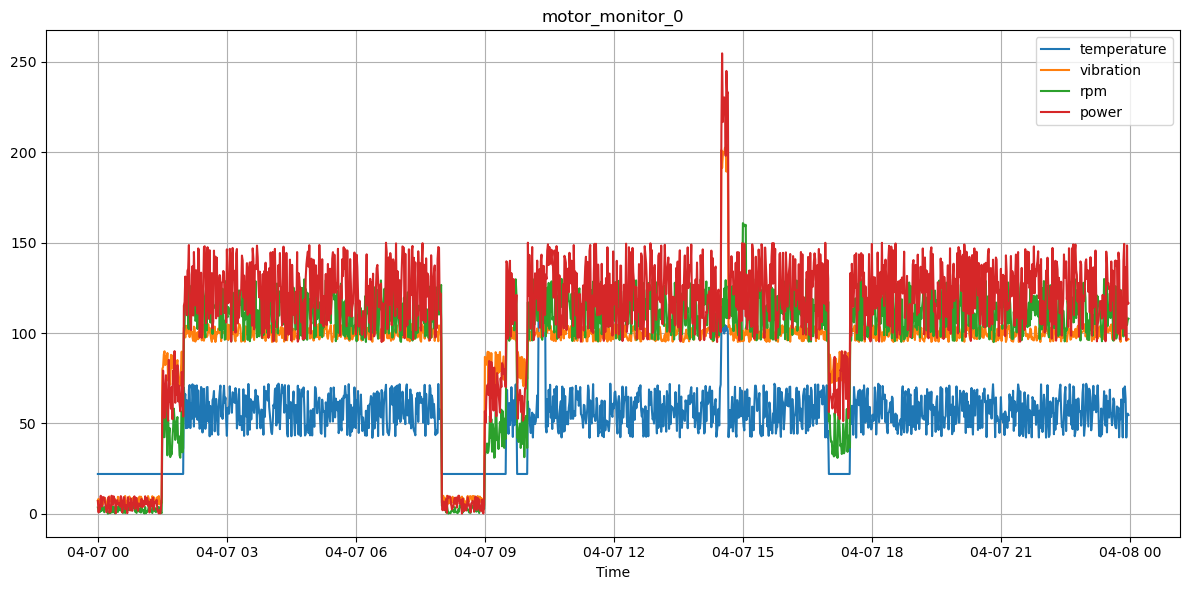

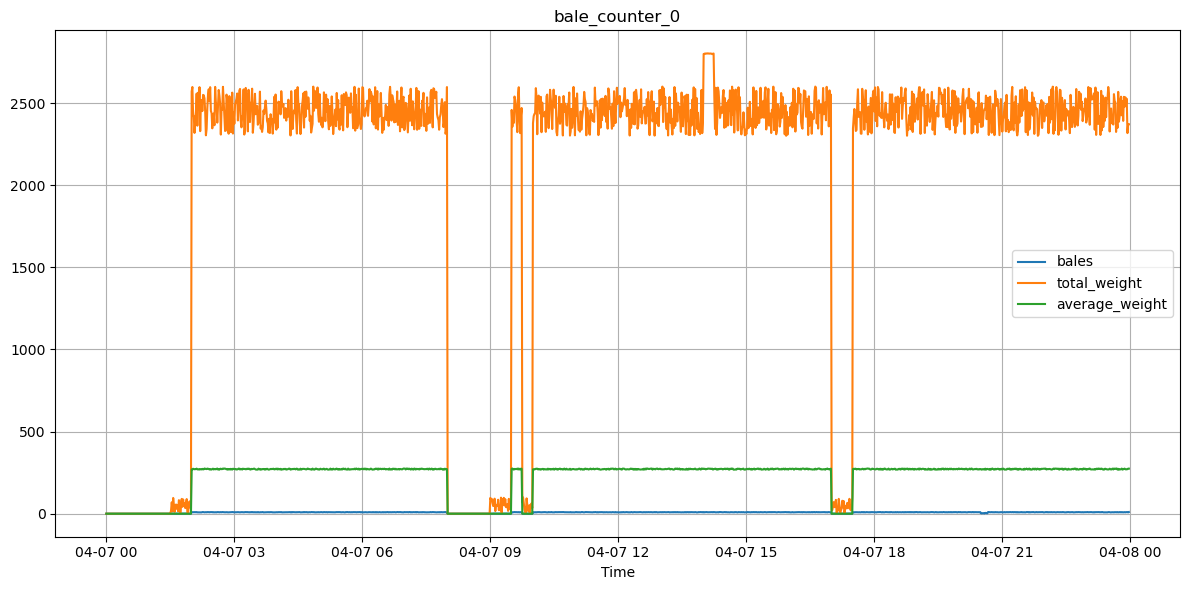

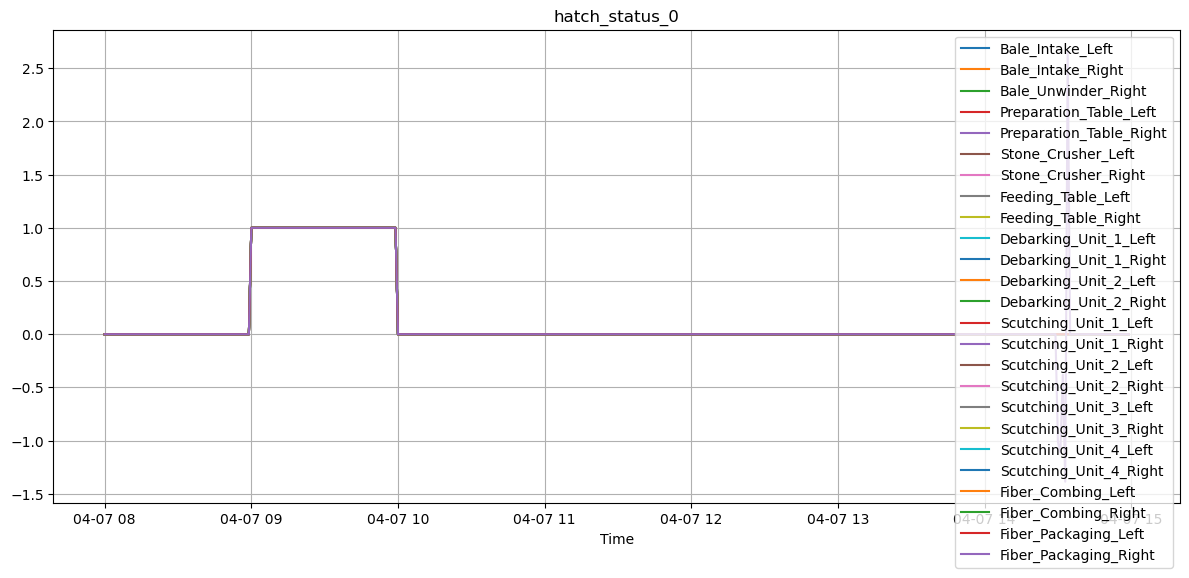

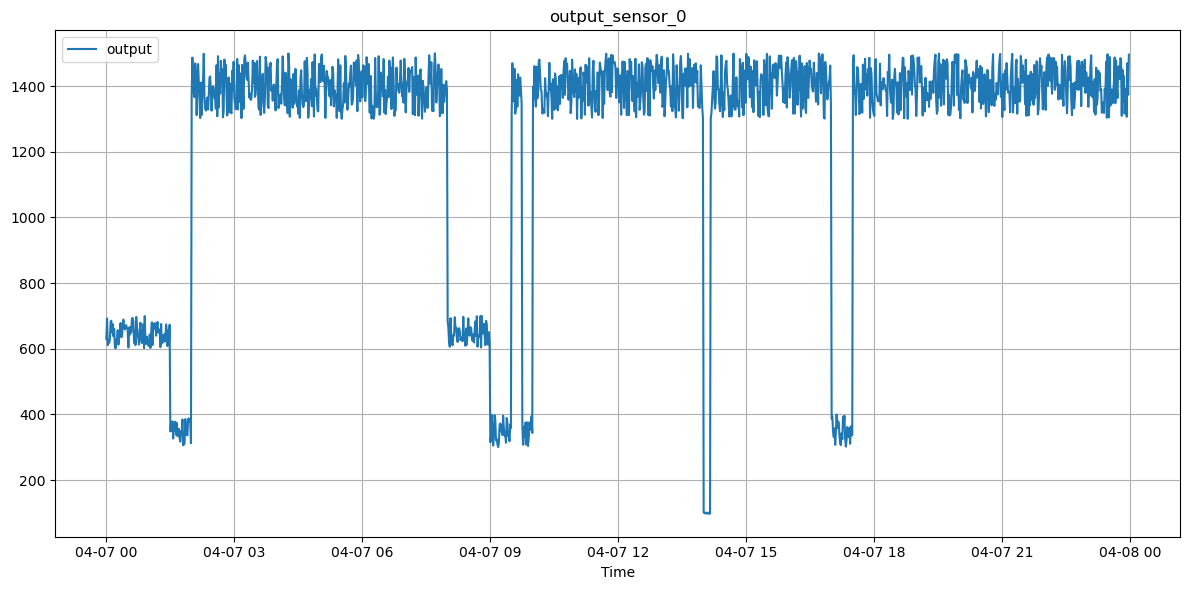

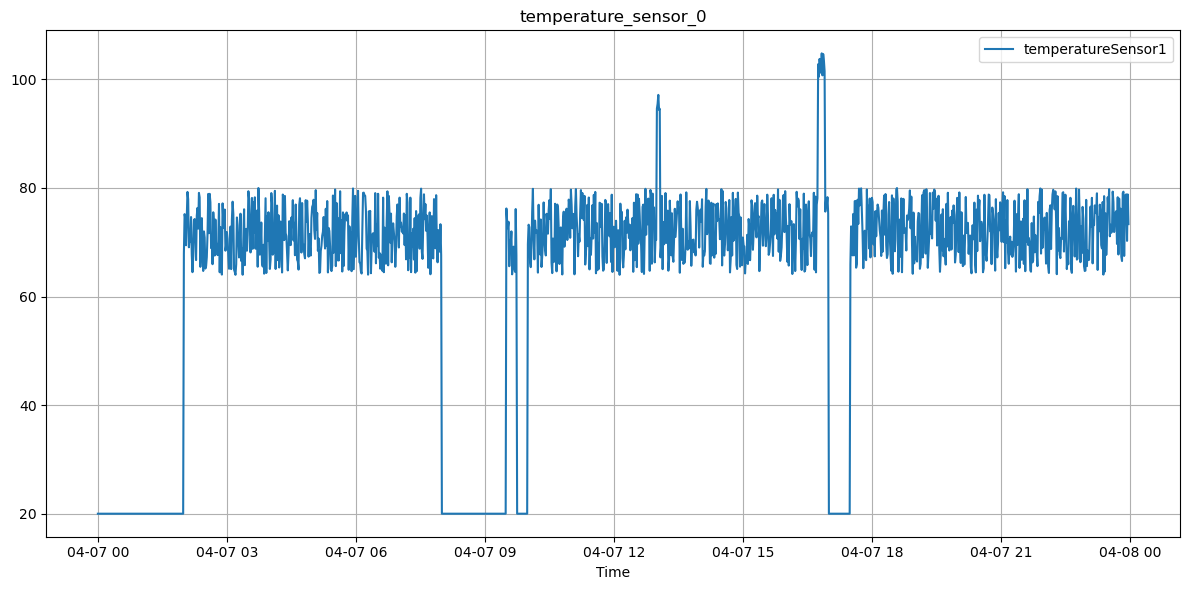

In [24]:
#for switching between batch and stream mode, change the "mode" under "synth_detial" in the json file

test_mode = "batch"  # or "stream"

# the batch mode
if (test_mode == "batch"):
    for key in dfs_dict:
        dfs = dfs_dict[key]
        combined_df = combined_df_dict[key]

        # Create plot
        plt.figure(figsize=(12, 6))
        for df in dfs:
            sensor_name = df["sensor"].iloc[0] if "sensor" in df.columns else "Unknown Sensor"
            plt.plot(df['timestamp'].to_numpy(), df['feature_0'].to_numpy(), label=sensor_name)

        plt.title(f"{key}")
        plt.xlabel("Time")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


        output_file = key.split("/")[-1] + ".csv"
        combined_df.to_csv(output_file, index=False)

# the stream mode
# will send the data one at a time
elif (test_mode == "stream"):
    global_stream_length = min(
        min(len(df) for df in dfs_list) for dfs_list in dfs_dict.values()
    )

    for i in range(global_stream_length):
        print(f"\n⏱Time step {i + 1}")

        for key, dfs_list in dfs_dict.items():
            for sensor_df in dfs_list:
                row_data = sensor_df.iloc[i].to_dict()
                print(f"[{key}] {row_data}")

        time.sleep(1)  # Simulate real-time streaming